## Code to generate Topoplots in Figure 3 and Figure 4

#### Written by Vinsea Singh on September 2023

Input:  'pre_param_ch_tr_wise.mat' - a MATLAB data containing all the periodic (CF,PW,BW) and aperiodic (offset, exponent) parameters.
'McG_110_1.cnt' - Raw EEG data of one participant to set montage and estimate fiducials for cluster-based permutation test analysis 

Output - Figure 3 and Figure 4 topoplots

Toolbox used for cluster-based permutation test - MNE-Python (MEG and EEG Analysis & Visualization Software). 
Link - https://mne.tools/stable/index.html                                            

In [1]:
##### Import libraries
import sys
import os
import numpy as np
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar

# Import MNE toolbox
!pip install mne
import mne
from mne import io
from mne.viz import *
from mne.stats import *

## Helper Functions

In [2]:
## EEG sensors montage using standard_1020
def eeg_sensor_pos(EEG):
    #extract the info
    EEG_info = EEG.info
    
    picks = mne.pick_channels(EEG.info['ch_names'], include=[], exclude=['VEO', 'HEO', 'EKG', 'EMG'])
    mne.pick_info(EEG.info, picks, copy=False)
    
    # Clean and replace channel names to be able to use a standard 1005 montage
    new_names = dict(
        (ch_names,
         ch_names.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp').
        replace('CB1','PO9').replace('CB2','PO10'))
        for ch_names in EEG.ch_names)
    EEG.rename_channels(new_names)
    
    # Form the 10-20 montage
    mont1020 = mne.channels.make_standard_montage('standard_1020')

    # Choose what channels you want to keep (64 channels)
    # Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
    kept_channels = ['Fp1','Fpz','Fp2','AF3','AF4','F7','F5','F3','F1','Fz','F2',
                     'F4', 'F6','F8','FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6',
                     'FT8','T7','C5','C3','C1','Cz','C2','C4','C6','T8','M1','TP7',
                     'CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8','M2','P7','P5',
                     'P3', 'P1','Pz','P2','P4','P6','P8','PO7','PO5','PO3','POz','PO4',
                     'PO6','PO8','PO9','O1','Oz','O2','PO10']

    ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
    mont1020_new = mont1020.copy()

    # Keep only the desired channels
    mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
    kept_channel_info = [mont1020.dig[x+3] for x in ind]

    # Keep the first three rows as they are the fiducial points information
    mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
    #mont1020.plot()
    #mont1020_new.plot()
    
    EEG.set_montage(mont1020_new,on_missing='warn')
    
    return(EEG, kept_channels)

In [3]:
## Function to check and convert NaN values to zero
def check_nans(data, nan_policy='zero'):
    """Check an array for nan values, and replace, based on policy."""

    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))

    # Apply desired nan policy to data
    if nan_policy == 'zero':
        data[nan_inds] = 0
    elif nan_policy == 'mean':
        data[nan_inds] = np.nanmean(data)
    elif nan_policy == 'median':
        data[nan_inds] = np.nanmedian(data)
    else:
        raise ValueError('Nan policy not understood.')

    return data

In [4]:
## Function to extract data from the dictionary 
def diff_val(param,prompt):
    if prompt == 'Offset':
        param_ta = np.array(param['off_ta'])
        param_pa = np.array(param['off_pa'])
    if prompt == 'Exponent':
        param_ta = np.array(param['exp_ta'])
        param_pa = np.array(param['exp_pa']) 
    if prompt == 'CF_alpha': 
        param_ta = np.array(param['cf_ta_alpha'])
        param_pa = np.array(param['cf_pa_alpha'])   
    if prompt == 'CF_beta':
        param_ta = np.array(param['cf_ta_beta'])
        param_pa = np.array(param['cf_pa_beta'])  
    if prompt == 'PW_alpha':
        param_ta = np.array(param['pw_ta_alpha'])
        param_pa = np.array(param['pw_pa_alpha'])   
    if prompt == 'PW_beta':
        param_ta = np.array(param['pw_ta_beta'])
        param_pa = np.array(param['pw_pa_beta'])   
    if prompt == 'BW_alpha':
        param_ta = np.array(param['bw_ta_alpha'])
        param_pa = np.array(param['bw_pa_alpha'])    
    if prompt == 'BW_beta':
        param_ta = np.array(param['bw_ta_beta'])
        param_pa = np.array(param['bw_pa_beta'])
        
    param_ta_nan = check_nans(param_ta)
    param_pa_nan = check_nans(param_pa)
    
    if np.size(param_pa,1) < np.size(param_ta,1):
        param_diff = param_ta_nan[:,-np.size(param_pa_nan,1):] - param_pa_nan
    else:
        param_diff = param_ta_nan - param_pa_nan[:,-np.size(param_ta_nan,1):]
        
    return(param_diff.T, param_ta_nan.T, param_pa_nan.T)

In [5]:
## Function to compute cluster-based permutation test
def cluster_stat(param, adjacency):
    # Set threshold
    pval = 0.05 
    df = np.size(param,1) - 1  # degrees of freedom for the test
    thresh = scipy.stats.t.ppf(1 - pval / 2, df)  # two-tailed, t distribution
    
    # Number of permutations
    n_perm = 1000
    
    # Cluster-based permutation test
    T_obs, clusters, p_values, h0 = permutation_cluster_1samp_test(param, adjacency=adjacency, threshold=thresh, 
                                                                n_permutations=1000, tail=0)
    
    # Isolate the significant cluster
    p_accept = 0.05
    good_cluster_inds = np.where(p_values < p_accept)[0]
    good_cluster_inds
        
    return(T_obs, clusters, p_values, good_cluster_inds)

In [6]:
def topo_plots(val, T_obs, good_cluster_inds, clusters, EEG, length, ax_val, param):
    
    # Figure layout
    fig, ax = plt.subplots(figsize=[8, 8], nrows=1, ncols=3, constrained_layout=True)
    
    #### Topoplots showing parameter distribution across scalp for illusory (McG /ta/) and non-illusory (McG /pa/) conditions
    # Find maximum and minimum Tmax value
    vmin = np.nanmin(val)
    vmax = np.nanmax(val)
    
    im1,_ = plot_topomap(val[0],EEG.info,size=10,vlim=[vmin, vmax],axes=ax[0],cmap='RdBu_r',sphere=0.1,
                         outlines='head',show=False)
    
    im2,_ = plot_topomap(val[1],EEG.info,size=10,vlim=[vmin, vmax],axes=ax[1],cmap='RdBu_r',sphere=0.1,
                         outlines='head',show=False)
    
    ax[0].set_title("McGurk /ta/",fontsize=18)
    ax[1].set_title("McGurk /pa/",fontsize=18)
    cax1 = fig.colorbar(im2,orientation='vertical', shrink=ax_val, ax=ax[:2])
    
    if param == "offset":
        cax1.set_label('$\mu$$V^2$',fontsize=15)
    if param == "exponent":
        cax1.set_label('$\mu$$V^2$$Hz^{-1}$',fontsize=15)
    if param == "cf":
        cax1.set_label('Frequency (Hz)',fontsize=15)
    if param == "pw":
        cax1.set_label('Power $\mu$$V^2$',fontsize=15)
    if param == "bw":
        cax1.set_label('Bandwidth (Hz)',fontsize=15)
        
    
    #### Topoplots showing significant clusters of sensors different between the two conditions
    for clu_idx in good_cluster_inds:
        # unpack cluster information, get unique indices
        cluster_idx = np.squeeze(clusters[clu_idx])
        cluster_chan = chan[cluster_idx]
        sig_sensor = np.unique(cluster_chan)
        stat_pick = mne.pick_channels(EEG.ch_names, sig_sensor)

        # create spatial mask
        mask = np.zeros((T_obs.shape[0], 1), dtype=bool)
        mask[stat_pick, :] = True
        
        T_obs_val = T_obs[cluster_idx]
        T_obs_sum = np.sum(T_obs_val)
        
        if T_obs_sum > 0:
            mask_param = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=8)
        else:
            mask_param = dict(marker='*', markerfacecolor='m', markeredgecolor='m', linewidth=0, markersize=8)
            
        vmin_cp = np.nanmin(T_obs)
        vmax_cp = np.nanmax(T_obs)
            
        im3,_ = plot_topomap(T_obs,EEG.info,axes=ax[2],mask=mask,mask_params=mask_param,vlim=[vmin_cp, vmax_cp],cmap='RdBu_r',
                        sphere=0.1,outlines='head',size=10,show=False)
    
    
    ax[2].set_title("McG /ta/ - McG /pa/",fontsize=18)
    cax3 = fig.colorbar(im3,orientation='vertical', shrink=ax_val, ax=ax[2])
    cax3.set_label('$t_{values}$',fontsize=20)

    return(fig)

## Set the montage and estimate fiducials to plot cluster sensors

In [7]:
# Import raw EEG .cnt file and set the montage
EEG =  mne.io.read_raw_cnt('Data/McG_110_1.cnt', preload=True)

EEG_montage, channels = eeg_sensor_pos(EEG)
EEG_montage.plot_sensors()
chan = np.array(channels)

Reading 0 ... 429879  =      0.000 ...   429.879 secs...


In [8]:
# Prepare Fiducials
adjacency, ch_names = mne.channels.find_ch_adjacency(EEG.info, ch_type="eeg")
mne.viz.plot_ch_adjacency(EEG.info, adjacency, ch_names)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64


## Load the dataset

In [9]:
# Load condition wise data
param = scipy.io.loadmat('Data/pre_param_ch_tr_wise.mat')

## Plot Figure 3A: Topoplots depicting periodic parameters' (CF, PW, BW) distributions across scalp for alpha frequency bands

In [10]:
#### Extract data from the Dictionary
## Alpha band
[cf_alpha_diff, cf_alpha_ta, cf_alpha_pa] = diff_val(param,'CF_alpha') # CF alpha
[pw_alpha_diff, pw_alpha_ta, pw_alpha_pa] = diff_val(param,'PW_alpha') # PW alpha
[bw_alpha_diff, bw_alpha_ta, bw_alpha_pa] = diff_val(param,'BW_alpha') # BW alpha

In [11]:
#### Compute cluster-based permutation test
## CF alpha (Center-Frequency)
T_cf_a, clusters_cf_a, p_cf_a, cluster_idx_cf_a  = cluster_stat(cf_alpha_diff,adjacency)

## PW alpha (Aperiodic adjusted power)
T_pw_a, clusters_pw_a, p_pw_a, cluster_idx_pw_a = cluster_stat(pw_alpha_diff,adjacency)

## BW alpha (Bandwidth)
T_bw_a, clusters_bw_a, p_bw_a, cluster_idx_bw_a = cluster_stat(bw_alpha_diff,adjacency)

stat_fun(H1): min=-4.147579 max=9.194765
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

stat_fun(H1): min=-8.824012 max=8.493424
Running initial clustering …
Found 7 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

stat_fun(H1): min=-3.287974 max=11.343045
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

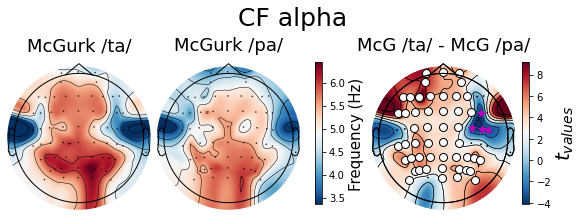

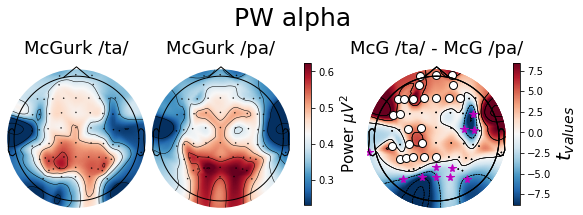

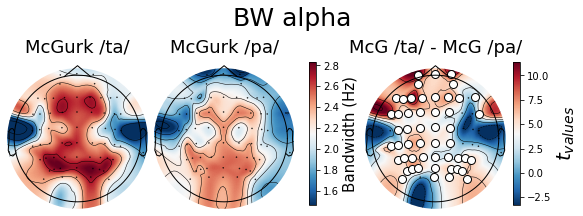

In [18]:
#### Plotting Figure 3A
# CF alpha 
cf_alpha = [np.mean(cf_alpha_ta,0), np.mean(cf_alpha_pa,0)]
fig = topo_plots(cf_alpha, T_cf_a, cluster_idx_cf_a, clusters_cf_a, EEG, length=2, ax_val=0.25, param="cf")
fig.suptitle("CF alpha", y=0.72, fontsize=25)
plt.show()

# PW alpha
pw_alpha = [np.mean(pw_alpha_ta,0), np.mean(pw_alpha_pa,0)]
fig = topo_plots(pw_alpha, T_pw_a, cluster_idx_pw_a, clusters_pw_a, EEG, length=2, ax_val=0.25, param="pw")
fig.suptitle("PW alpha", y=0.72, fontsize=25)
plt.show()

# BW alpha
bw_alpha = [np.mean(bw_alpha_ta,0), np.mean(bw_alpha_pa,0)]
fig = topo_plots(bw_alpha, T_bw_a, cluster_idx_bw_a, clusters_bw_a, EEG, length=2, ax_val=0.25, param="bw")
fig.suptitle("BW alpha", y=0.72, fontsize=25)
plt.show()

## Plot Figure 3B: Topoplots depicting periodic parameters' (CF, PW, BW) distributions across scalp for beta frequency bands

In [19]:
#### Extract data from the Dictionary
## Beta band
[cf_beta_diff, cf_beta_ta, cf_beta_pa] = diff_val(param,'CF_beta') # CF beta
[pw_beta_diff, pw_beta_ta, pw_beta_pa] = diff_val(param,'PW_beta') # PW beta
[bw_beta_diff, bw_beta_ta, bw_beta_pa] = diff_val(param,'BW_beta') # BW beta

In [20]:
#### Compute cluster-based permutation test
## CF beta (Center-Frequency)
T_cf_b, clusters_cf_b, p_cf_b, cluster_idx_cf_b  = cluster_stat(cf_beta_diff,adjacency)

## PW beta (Aperiodic adjusted power)
T_pw_b, clusters_pw_b, p_pw_b, cluster_idx_pw_b = cluster_stat(pw_beta_diff,adjacency)

## BW beta (Bandwidth)
T_bw_b, clusters_bw_b, p_bw_b, cluster_idx_bw_b = cluster_stat(bw_beta_diff,adjacency)

stat_fun(H1): min=-13.342169 max=0.987563
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

stat_fun(H1): min=-16.448837 max=2.089070
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

stat_fun(H1): min=-14.875636 max=-1.024686
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

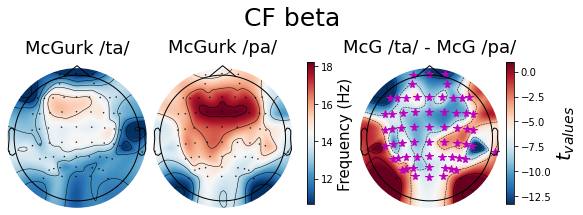

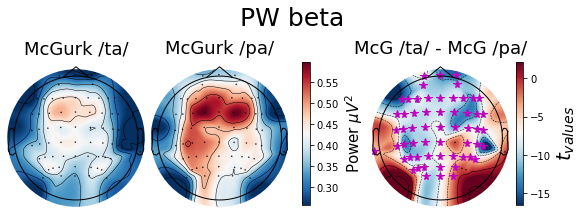

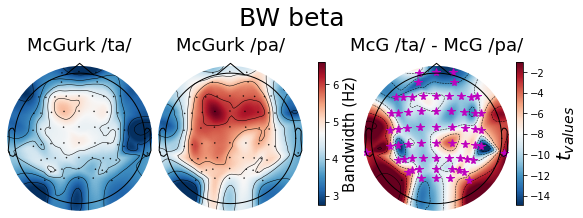

In [21]:
#### Plotting Figure 3B
# CF beta 
cf_beta = [np.mean(cf_beta_ta,0), np.mean(cf_beta_pa,0)]
fig = topo_plots(cf_beta, T_cf_b, cluster_idx_cf_b, clusters_cf_b, EEG, length=2, ax_val=0.25, param="cf")
fig.suptitle("CF beta", y=0.72, fontsize=25)
plt.show()

# PW alpha
pw_beta = [np.mean(pw_beta_ta,0), np.mean(pw_beta_pa,0)]
fig = topo_plots(pw_beta, T_pw_b, cluster_idx_pw_b, clusters_pw_b, EEG, length=2, ax_val=0.25, param="pw")
fig.suptitle("PW beta", y=0.72, fontsize=25)
plt.show()

# BW alpha
bw_beta = [np.mean(bw_beta_ta,0), np.mean(bw_beta_pa,0)]
fig = topo_plots(bw_beta, T_bw_b, cluster_idx_bw_b, clusters_bw_b, EEG, length=2, ax_val=0.25, param="bw")
fig.suptitle("BW beta", y=0.72, fontsize=25)
plt.show()

## Plot Figure 4: Topoplots depicting aperiodic parameters' (Offset and Exponent) distributions across scalp

In [22]:
#### Extract data from the Dictionary
## Offset
[off_diff, off_ta, off_pa] = diff_val(param,'Offset')

## Exponent
[exp_diff, exp_ta, exp_pa] = diff_val(param,'Exponent')

In [23]:
#### Compute cluster-based permutation test
## Offset
T_off, clusters_off, p_off, cluster_idx_off = cluster_stat(off_diff,adjacency)

## Exponent
T_exp, clusters_exp, p_exp, cluster_idx_exp = cluster_stat(exp_diff,adjacency)

stat_fun(H1): min=-22.885876 max=5.778094
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

stat_fun(H1): min=-25.752430 max=13.055708
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

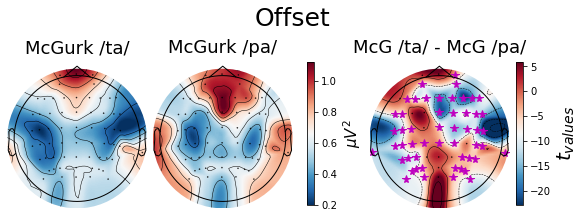

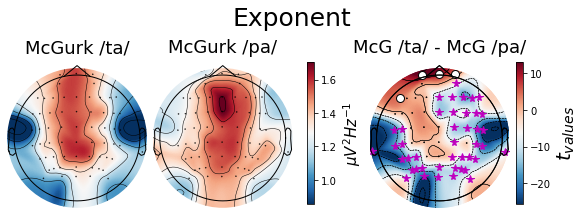

In [24]:
#### Plotting Figure 4
# Offset 
offset = [np.mean(off_ta,0), np.mean(off_pa,0)]
fig = topo_plots(offset, T_off, cluster_idx_off, clusters_off, EEG, length=2, ax_val=0.25, param="offset")
fig.suptitle("Offset", y=0.72, fontsize=25)
plt.show()

# Exponent
exponent = [np.mean(exp_ta,0), np.mean(exp_pa,0)]
fig = topo_plots(exponent, T_exp, cluster_idx_exp, clusters_exp, EEG, length=2, ax_val=0.25, param="exponent")
fig.suptitle("Exponent", y=0.72, fontsize=25)
plt.show()